If $f$ (objective function) is cheap to evaluate we can sample various points and built a potential surface however, if the $f$ is expensive -- like in case of first-principles electronic structure calculations, it is important to minimize the number of $f$ calls and number of samples drawn from this evaluation. In that case, if an exact functional form for f is not available (that is, f behaves as a “black box”), what can we do? 

Bayesian optimization proceeds by maintaining a probabilistic belief about $f$ and designing a so called **_acquisition function_** to determine where to evaluate the next function call. Bayesian optimization is particularly well-suited to global optimization problems where:
1. $f$ is an expensive black-box function
2. Analytical solution for the gradient of the function is difficult to evaluate 

The idea is the find "global" minimum with least number of steps. Incorporating _prior_ beliefs about the underlying process and update the _prior_ with samples draw from the model to better estimate the _posterior_. 

Model used for approximating the objective function is called the **_surrogate model_**. 

Following are few links I have found useful in understanding the inner workings of the Bayesian opitmization and certain typical surrogate functions used in it: 

* Good introductory write-up on Bayesian optimization [(Distill Blog)](https://distill.pub/2020/bayesian-optimization/)

* Nice lecture explaining the working of Gaussian Processes [here](https://www.youtube.com/watch?v=92-98SYOdlY&t=4827s)

### Surrogate model 

A popular surrogate model applied for Bayesian optimization, although strictly not required, are Gaussian Processes (GPs). These are used to define a prior beliefs about the objective function. The GP posterior is cheap to evaluate and is used to propose points in the search space where sampling is likely to yield an improvement. Herein, we could substitute this for a ANNs or other surrogate models. 

### Acquisition functions 
Used to propose sampling points in the search space. Have to consider the trade-off between exploitation vs exploration. 

* Exploitation == sampling where objective function value is high

* Exploration == where uncertainty is high

Both correspond to high `acquisition function` value. The goal is the maximize the acquisition value to determine next sampling point. 

**Popular acquisition functions:**

1. Maximum probability of improvement    

>PI involves sampling for points which improve on the current best objective function value. The point in the sample space with the highest probability of improvement, based on the value predicted by the surrogate function, is chosen as the next point for evaluating through the expensive method. However in this searching scheme we look only at the probability improvement and not the extent of improvement. This might lead it to get stuck in a local minima. Instead we can turn to the __Expected value__ of improvement wherein we consider the extent of improvement as well.

2. Expected improvement (EI)

3. Upper confidence bound (UCB)

### Optimization strategy 

Following strategy is followed when optimizing using Bayesian optimization: 
<ul> 
    <li>Find the next sampling point $\mathbf{x}_t$ by optimizing the acquisition function over a surrogate model (in this case a GP) fit over a distribution $\mathcal{D}_{1:t-1}$</li>
    <li>Evaluate $f$ at $f(x_{t})$ i.e. sample $f(x_{t})$ from the $f$</li>
    <li>Add the new point to the prior of the GP now $\mathcal{D}_{1:t} = ( \mathcal{D}_{1:t-1}, (x_{t},f(x_{t})) )$</li>
</ul>

### Expected improvement

Expected improvement is defined as: 
$$\mathrm{EI}(\mathbf{x}) = \max((f(\mathbf{x}) - f(\mathbf{x}^+), 0))\tag{1}$$

where $f(\mathbf{x}^+)$ is the value of the best sample so far and $\mathbf{x}^+$ is the location of that sample i.e. $\mathbf{x}^+ = \mathrm{argmax}_{\mathbf{x}_i \in \mathbf{x}_{1:t}} f(\mathbf{x}_i)$. The expected improvement can be evaluated analytically under the GP model

Expected improvement can be evaluated analytically for a GP model. 


Before diving in the technical details, I would like to acknowledge the work of Noah Wichrowski (JHU) in building the necessary ground work for the bayesian optimization routine implemented in this article. 

### Implementation with Numpy and Scipy 

In [16]:
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'

# Plot matplotlib plots with white background: 
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels

In [17]:
from Bayesian_optimization import plotting_utils, acquisition, objectives, opti

In [18]:
plot_params = {
'font.size' : 22,
'axes.titlesize' : 24,
'axes.labelsize' : 20,
'axes.labelweight' : 'bold',
'xtick.labelsize' : 16,
'ytick.labelsize' : 16,
}
 
plt.rcParams.update(plot_params)

## ## Import the acquisition functions implemented 

In [19]:
EI = acquisition.ExpectedImprovement(delta = 0.01)
LCB = acquisition.LowerConfidenceBound(sigma = 1.96)

# A One-Dimensional Example

### Egg-carton objective function 

In [20]:
objective = objectives.egg_carton
(low, high) = (0.0, 10.0)
domain = np.array([[low], [high]])
x_pts = np.linspace(low, high, 1000).reshape(-1, 1)
y_pts = objective(x_pts)

In [21]:
num_sample_points = 10
noise_ = 0.1
generator = np.random.default_rng(42)
x_sample = generator.uniform(low, high, size = (num_sample_points, 1))
y_sample = objective(x_sample, noise_)

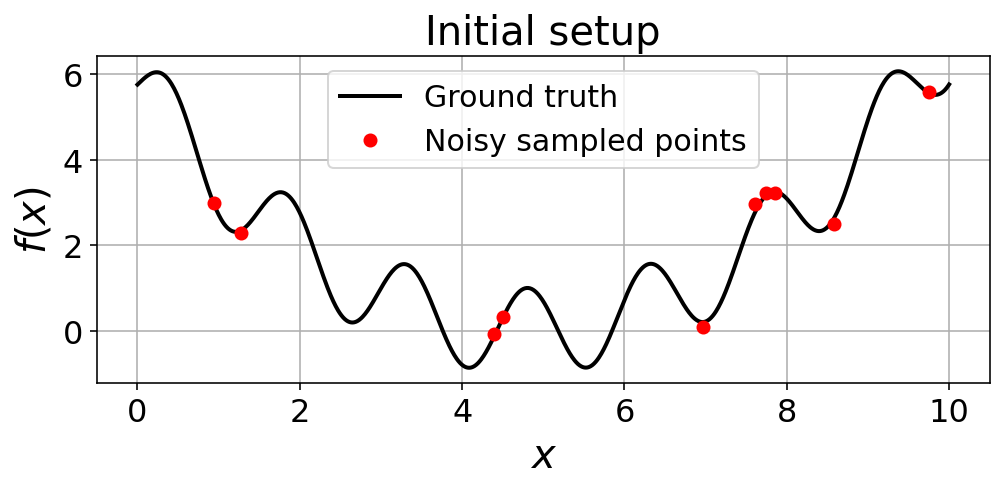

In [22]:
fig, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(x_pts, y_pts, 'k-', linewidth=2.0, label='Ground truth')
ax.plot(x_sample, y_sample, 'ro', label='Noisy sampled points')

ax.set_xlabel(r"$x$", fontsize = 20)
ax.set_ylabel(r"$f(x)$", fontsize = 20)
ax.set_title("Initial setup", fontsize = 20)
ax.legend(fontsize = 15)
ax.grid(True)

## Fit a GPR model (surrogate function) to the sampled points

In [23]:
constant = kernels.ConstantKernel()
matern = kernels.Matern(nu = 2.5)
rbf = kernels.RBF()

gpr_model = GPR(kernel = constant*rbf, alpha = 1e-3, n_restarts_optimizer = 20, normalize_y = False, random_state = 42)

gpr_model.fit(x_sample, y_sample)

GaussianProcessRegressor(alpha=0.001, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=20, random_state=42)

In [24]:
(mean_pred, stddev_pred) = gpr_model.predict(x_pts, return_std = True)
gpr_model.kernel_

2.78**2 * RBF(length_scale=0.782)

## Plot the Initial Sample

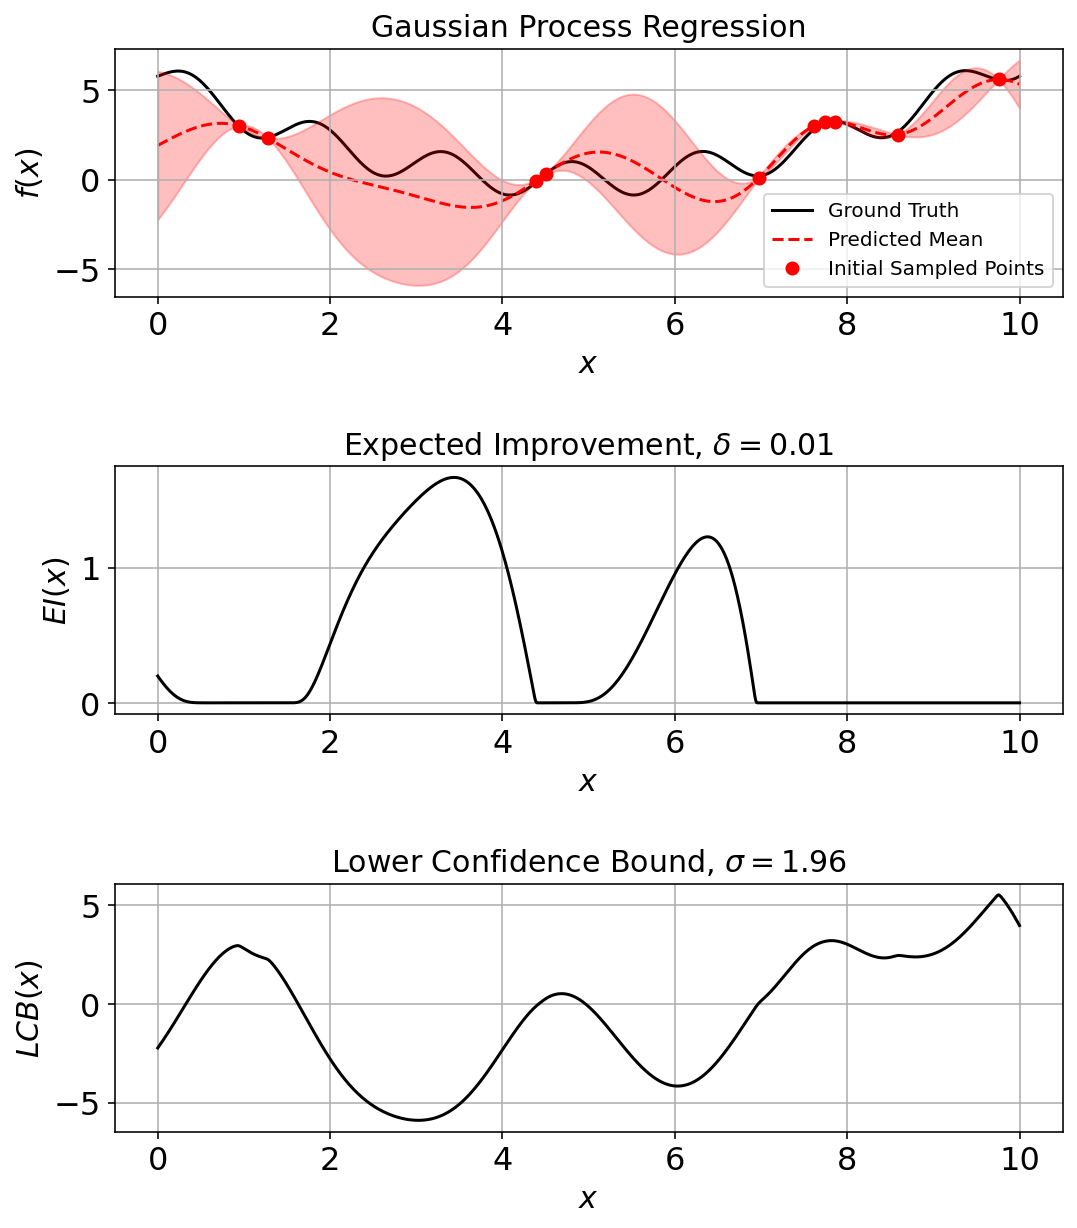

In [25]:
(fig_ec, ax_ec) = plotting_utils.illustrate_1d_gpr(objective, gpr_model, x_pts, EI, LCB)

## Run a Few Iterations and Assess

In [26]:
pkwargs = {"num_sample": 10,
           "num_improve": 5,
           "generator": generator}

res_ec, _ = opti.bayesian_optimization(objective, gpr_model, LCB, domain, max_iter=10, noise=noise_, prop_kwargs = pkwargs)
gpr_model.fit(res_ec["X"], res_ec["y"]) # Incorporate final point into plots.

10


GaussianProcessRegressor(alpha=0.001, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=20, random_state=42)

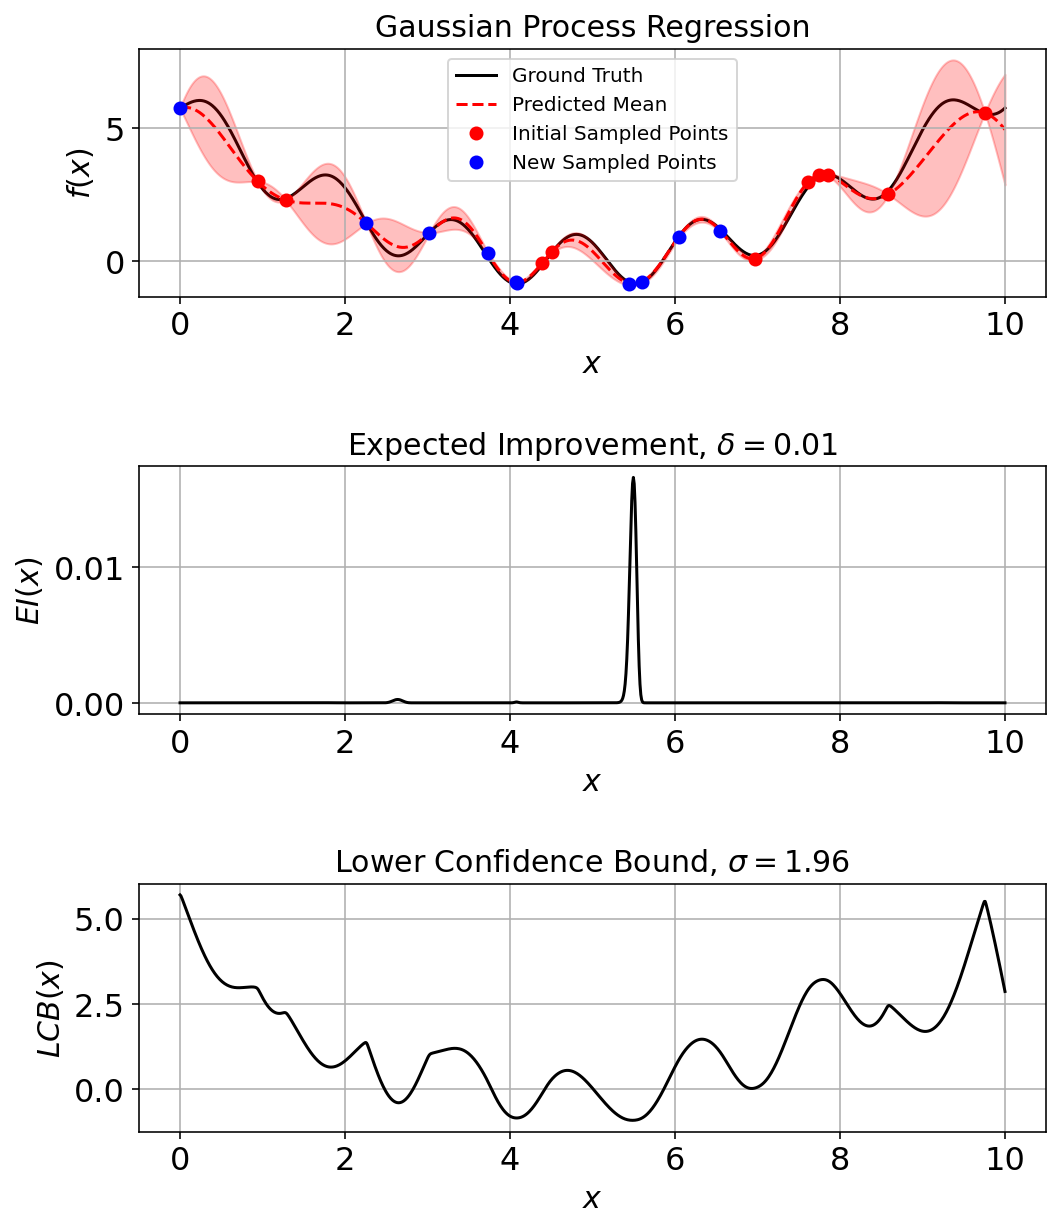

In [27]:
(fig_ec, ax_ec) = plotting_utils.illustrate_1d_gpr(objective, gpr_model, x_pts, EI, LCB, num_sample_points)

## Run a Few More Iterations

In [28]:
res_ec, _ = opti.bayesian_optimization(objective, gpr_model, LCB, domain, noise=noise_, prop_kwargs = pkwargs)
gpr_model.fit(res_ec["X"], res_ec["y"]) # Incorporate final point into plots.

20


GaussianProcessRegressor(alpha=0.001, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=20, random_state=42)

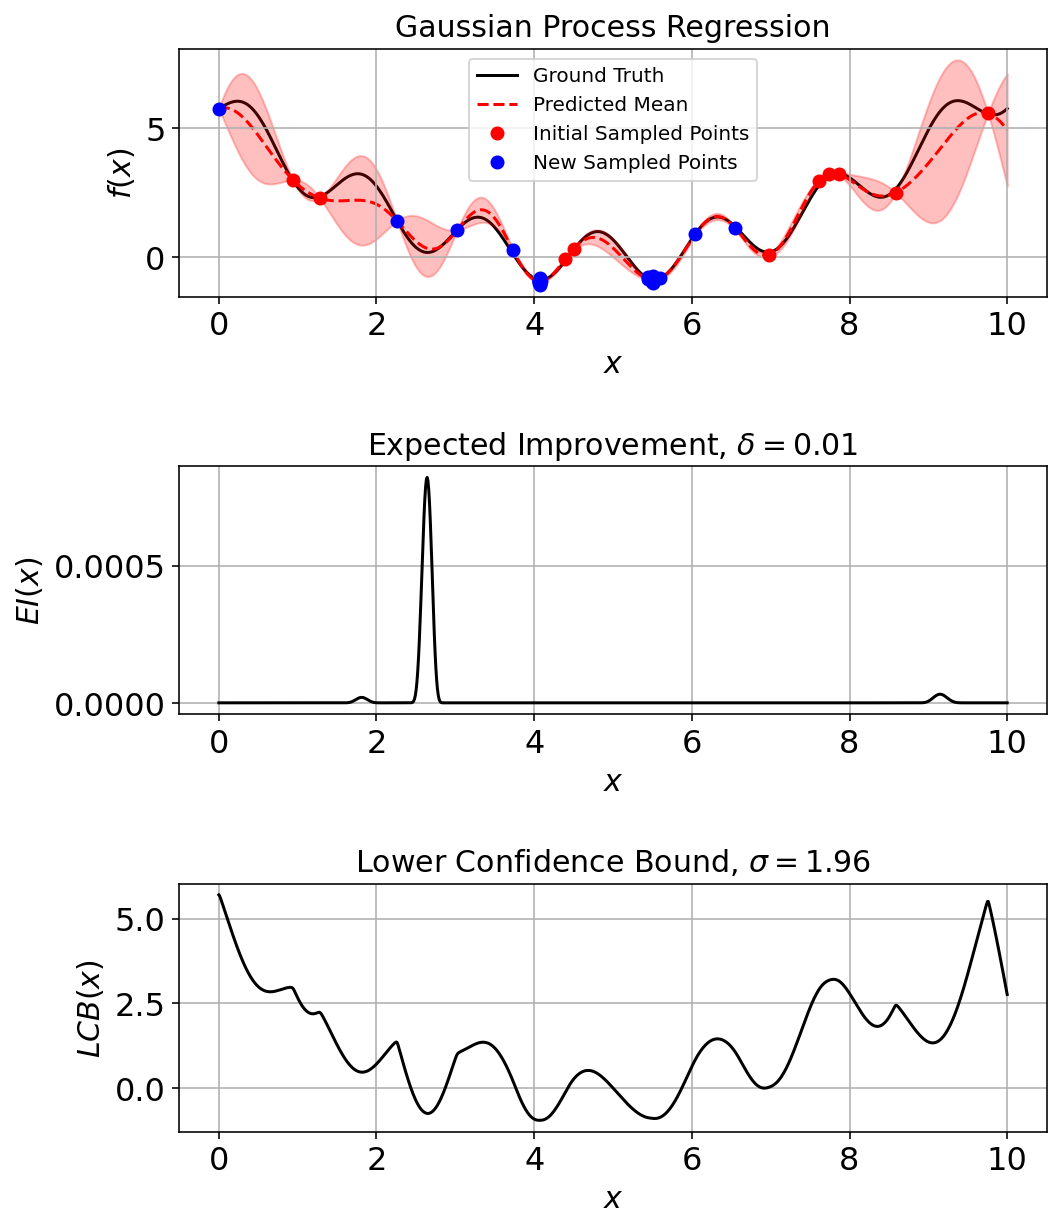

In [29]:
(fig_ec, ax_ec) = plotting_utils.illustrate_1d_gpr(objective, gpr_model, x_pts, EI, LCB, num_sample_points)

In total the noisy estimation of the ground-truth is conducted on 30 additional points. It is evident from the plot that most of those points are near the x = (4,6) since that is the minimum value region for the function.  